<a href="https://colab.research.google.com/github/RIPS-2024-Aerospace/Aerospace-Project/blob/main/CentralizedLunarKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pre-defined values from Lunar Time-Transfer paper to define Q and R**

In [62]:
import numpy as np
import math

# constant terms, given in Bhamidipati et. al
T_c = 0.00000009775
f_L1 = 1575420000
N_i = 4
CN0 = 15
B_pll = 0.5
B_fe = 26000000
T = 0.020
d = 0.3
pi = math.pi
c = 299792458
B_dll = 0.5

s_dll = (B_dll/(2*CN0))*(1/(T_c*B_fe))*(1+(1/(T*CN0))) # Equation (22)
pr_var = ((c*T_c)**2)*s_dll # pseudorange variance

s_pll = (B_pll/(CN0))*(1+(1/(2*T*CN0))) # Equation (33)
prr_var = ((c**2)/((2*pi*f_L1 * T_c)**2)) * (s_pll) # pseudorange rate variance


# Assuming 2 satellites, R is the measurement noise covariance matrix
R = np.array([[pr_var,0,0,0],[0,pr_var,0,0],[0,0,prr_var,0],[0,0,0,prr_var]])
print(R)

[[2.44036996e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.44036996e+01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.53302279e+09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.53302279e+09]]


In [63]:
# more constant terms, pertinent to Q matrix
# Q is process noise covariance matrix
h_0 = 1.4*(10**(-22))
h_m1 = 2.3*(10**(-26))
h_m2 = 3.3*(10**(-31))

dt = 60

e1 = (h_0/2)*dt + 2*h_m1*(dt*dt) + (2/3)*((pi*h_m2*dt)**2)*dt
e2 = h_m1*dt + h_m2*(pi*dt)**2
e3 = (h_0/(2*dt))+ 4*h_m1 + (8/3)*(pi*pi)*h_m2*dt

Q = np.array([[e1,e2],[e2,e3]])
print(Q)

[[4.36560000e-21 1.39172509e-24]
 [1.39172509e-24 1.25918778e-24]]


In [64]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

class KalmanFilter(object):
  # Initialize the Kalman Filter with parameters
  def __init__(self, A = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):
    if(A is None or H is None):
      raise ValueError("Set proper system dynamics.")

    # number of state variables
    self.n = A.shape[1]

    # number of measurement variables
    self.m = H.shape[1]

    # assign the system matrices, using default values
    self.A = A
    self.H = H
    self.B = np.zeros((1,1)) if B is None else B

    # covariance is often a diagonal matrix since variables are independent
    self.Q = np.eye(self.n) if Q is None else Q # process noise covariance matrix
    self.R = np.eye(self.n) if R is None else R # measurement noise covariance matrix
    self.P = np.eye(self.n) if P is None else P # the initial error estimate covariance matrix
    self.x = np.zeros((self.n, 1)) if x0 is None else x0 # the initial state estimate vector

  # Prediction step of the Kalman filter
  def predict(self, u = None):
    if u is None: u = np.zeros((self.B.shape[1],1))

    self.x = (self.A @ self.x) + (self.B @ u) # predict the next state estimate
    self.P = ((self.A @ self.P) @ self.A.T) + self.Q # predict the next estimate error covariance
    return self.x

  # Update step of the Kalman Filter
  def update(self, z):
    S = self.R + (self.H @ (self.P @ self.H.T)) # calculate the measurement residual covariance
    K = sp.linalg.cho_solve(sp.linalg.cho_factor(S.T),(self.H @ self.P.T)).T # Kalman gain using a Cholesky solver
    y = z - (self.H @ self.x) # calculate the measurement residual
    self.x = self.x + (K @ y) # update the state estimate

    # update the estimate error covariance
    I = np.eye(self.n)
    self.P = (((I - (K @ self.H)) @ self.P) @ ((I - (K @ self.H)).T))+(K @ (self.R @ K.T))
    return K

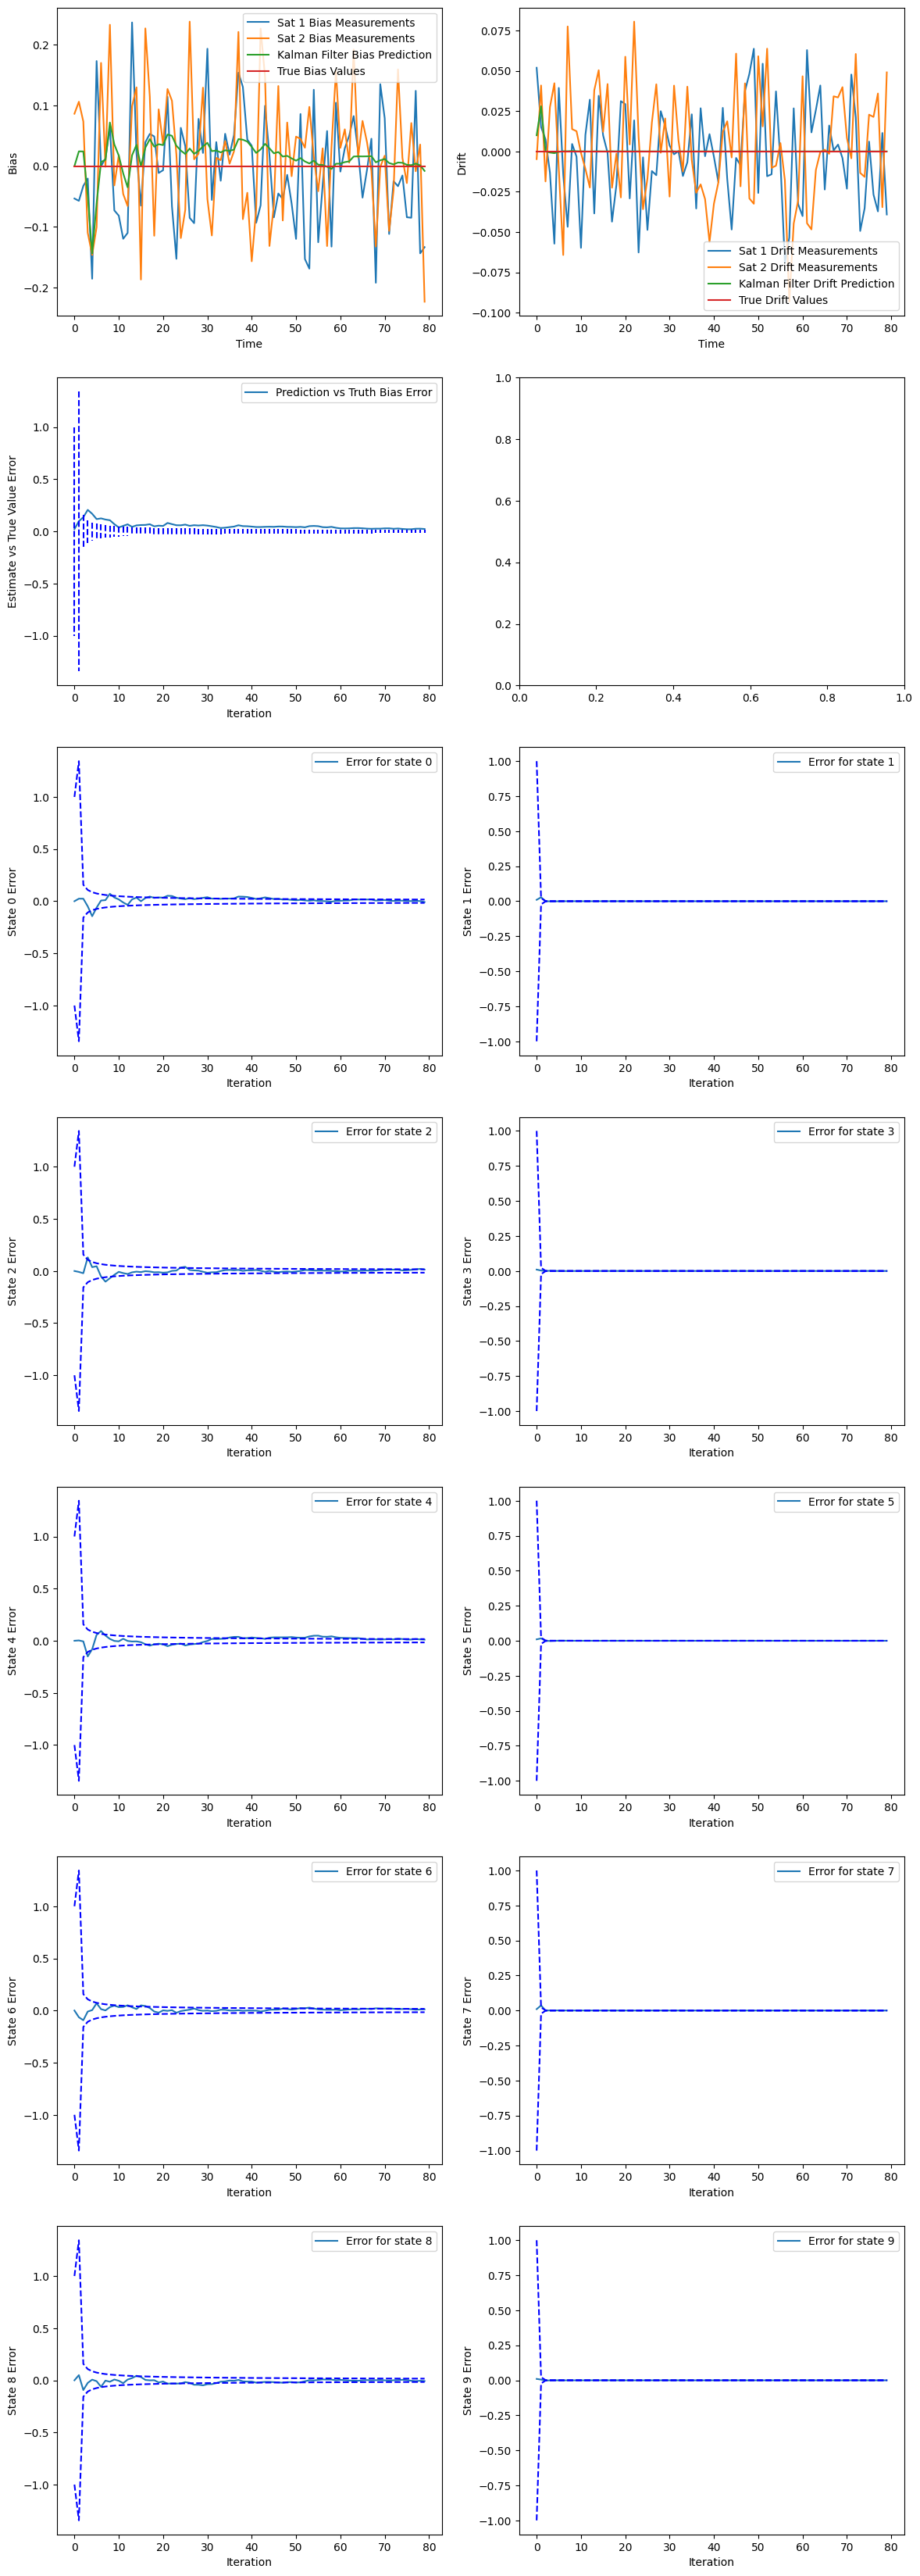

In [65]:
def example():
    # the defined system dynamics matrix
    A = np.array([[1, 60, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 60, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 60, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 60, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 60],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

    # set up measurement matrix H
    H = np.array([[1, 0], [1, 0], [0, 1], [0, 1]])
    H_20x10 = np.zeros((20, 10))
    for i in range(0, 20, 4):
        H_20x10[i:i+4, i//2:i//2+2] = H

    # set up process noise covariance matrix Q
    Q_10x10 = np.zeros((10, 10))
    for i in range(0, 10, 2):
        Q_10x10[i:i+2, i:i+2] = Q

    # set up measurement noise covariance matrix R
    R_20x20 = np.zeros((20, 20))
    R = np.array([[0.01,0,0,0],[0,0.01,0,0],[0,0,0.001,0],[0,0,0,0.001]])
    # R = np.array([[pr_var,0,0,0],[0,pr_var,0,0],[0,0,prr_var,0],[0,0,0,prr_var]]), this is the original R
    for i in range(0, 20, 4):
        R_20x20[i:i+4, i:i+4] = R

    # First Estimate Value (initial state)
    x = np.array([[0, 0.01, 0, 0.01, 0, 0.01, 0, 0.01, 0, 0.01]]).T

    # Initial Truth Value
    x0 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).T

    # Initialize Kalman Filter
    kf = KalmanFilter(A = A, H = H_20x10, Q = Q_10x10, R = R_20x20, x0 = x)

    # Process Noise and Measurement Noise Functions
    procc_noise = lambda : np.linalg.cholesky(Q_10x10) @ np.random.normal(np.array([[0 for _ in range(10)]]).T)
    measure_noise = lambda : np.linalg.cholesky(R_20x20) @ np.random.normal(np.array([[0 for _ in range(20)]]).T)

    # Generate initial measurement
    z = (H_20x10 @ x0) + measure_noise()

    # Initialize the lists to store results
    truth = [x0]
    predictions = [x]
    measurements = [z]
    errors = [(x-x0)]
    P_hist = [kf.P]

    # Run Kalman Filter for 80 iterations
    iterations = 80
    for i in range(iterations-1):
        truth.append((A@truth[-1]) + procc_noise()) # Get new truth with process noise

        z = (H_20x10 @ truth[-1]) + measure_noise() # Get new measurements with measurement noise
        measurements.append(z)

        kf.update(z) # Correct estimate using measurement

        predictions.append(kf.x) # Record updated estimate and error
        errors.append(kf.x - truth[-1])

        x = kf.predict() # Predict next step

        P_hist.append(kf.P) # Append the covariance matrix history

    # Creating subplots
    fig,axs = plt.subplots(7,2, figsize=(14, 42))
    for i in range(1):
        # Plot bias and drift measurements, predictions, and true values
        axs[0][0].plot([i for i in range(iterations)],[x[4*i][0] for x in measurements], label = 'Sat 1 Bias Measurements')
        axs[0][0].plot([i for i in range(iterations)],[x[4*i+1][0] for x in measurements], label = 'Sat 2 Bias Measurements')
        axs[0][0].plot([i for i in range(iterations)],[x[2*i][0] for x in predictions], label = 'Kalman Filter Bias Prediction')
        axs[0][0].plot([i for i in range(iterations)],[x[2*i][0] for x in truth], label = 'True Bias Values')
        axs[0][0].set_xlabel("Time")
        axs[0][0].set_ylabel("Bias")
        axs[0][0].legend()

        axs[0][1].plot([i for i in range(iterations)],[x[4*i+2][0] for x in measurements], label = 'Sat 1 Drift Measurements')
        axs[0][1].plot([i for i in range(iterations)],[x[4*i+3][0] for x in measurements], label = 'Sat 2 Drift Measurements')
        axs[0][1].plot([i for i in range(iterations)],[x[2*i+1][0] for x in predictions], label = 'Kalman Filter Drift Prediction')
        axs[0][1].plot([i for i in range(iterations)],[x[2*i+1][0] for x in truth], label = 'True Drift Values')
        axs[0][1].set_xlabel("Time")
        axs[0][1].set_ylabel("Drift")
        axs[0][1].legend()

        # Convert errors and covariance history to numpy arrays
        errors = np.array(errors).squeeze()
        error_norm = np.linalg.norm(errors, axis=1)
        P_hist = np.array(P_hist)
        t_hist = np.arange(iterations)

        # Plot prediction vs truth bias error
        axs[1][0].plot(t_hist, error_norm, label='Prediction vs Truth Bias Error')
        axs[1][0].plot(np.vstack([t_hist, t_hist]), np.vstack([np.sqrt(P_hist[:, 0, 0]), -np.sqrt(P_hist[:, 0, 0])]), 'b--')
        axs[1][0].legend()
        axs[1][0].set_xlabel("Iteration")
        axs[1][0].set_ylabel("Estimate vs True Value Error")

        # Plot error and covariance bounds for each state variable
        for k in range(10):
            error_k = errors[:, k]
            cov_k = np.sqrt(P_hist[:, k, k])
            row, col = divmod(k, 2)
            axs[row+2, col].plot(t_hist, error_k, label=f'Error for state {k}')
            axs[row+2, col].plot(np.vstack([t_hist, t_hist]).T, np.vstack([cov_k, -cov_k]).T, 'b--')
            axs[row+2, col].legend()
            axs[row+2, col].set_xlabel("Iteration")
            axs[row+2, col].set_ylabel(f"State {k} Error")

        plt.show()

if __name__ == '__main__':
    example()